### Diabetes Case Study

现在你将有机会使用一系列的监督学习技术来进行分类和回归。将这些应用到项目中之前，让我们再举一个例子，用另一个流行数据集来从头到尾了解一下机器学习的工作流程。

In [14]:
# Import our libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
sns.set(style="ticks")

import check_file as ch

%matplotlib inline

# Read in our dataset
diabetes = pd.read_csv('diabetes.csv')

# Take a look at the first few rows of the dataset
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


我们将从加载数据和导入相关库开始。然后，你将了解如何使用网格搜索来优化多个模型。因为这门课程的目的是了解机器学习技术，所以我们在很大程度上省略了创建机器学习模型前的数据分析阶段的相关过程，包括探索性数据分析、特征工程、数据清理和数据整理等。

> **步骤 1：** 让我们完成下面几个步骤。先看一下这个数据集的一些摘要统计数据，以便准确地将统计值与下面的字典中的适当键进行匹配。

In [15]:
# Cells for work
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# sns.pairplot 

[http://seaborn.pydata.org/generated/seaborn.pairplot.html](http://seaborn.pydata.org/generated/seaborn.pairplot.html)

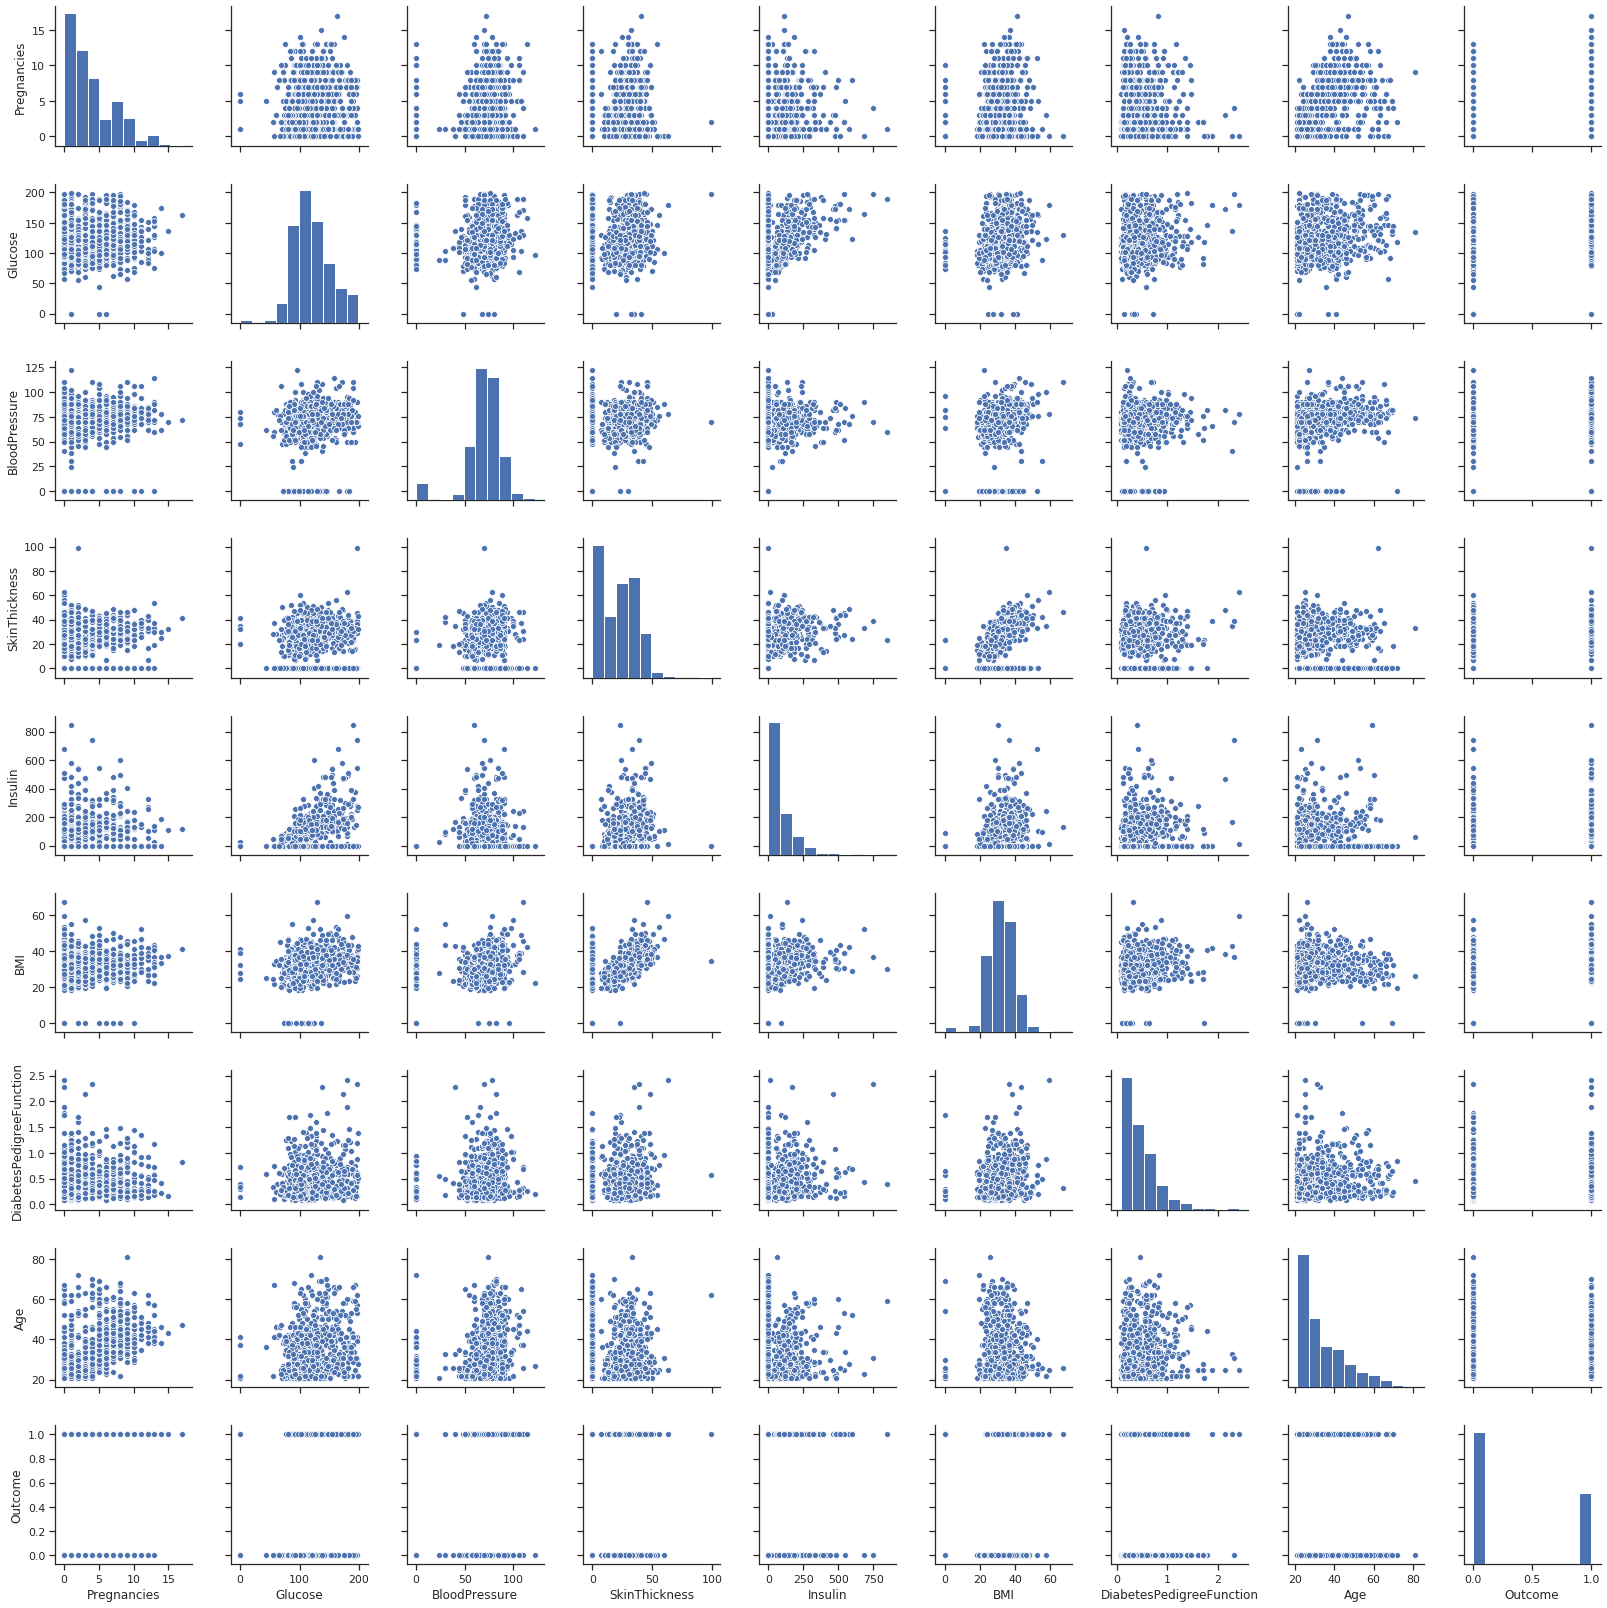

In [23]:
#可以看到对角线上是各个属性的直方图（分布图），而非对角线上是两个不同属性之间的相关图
sns.pairplot(diabetes)

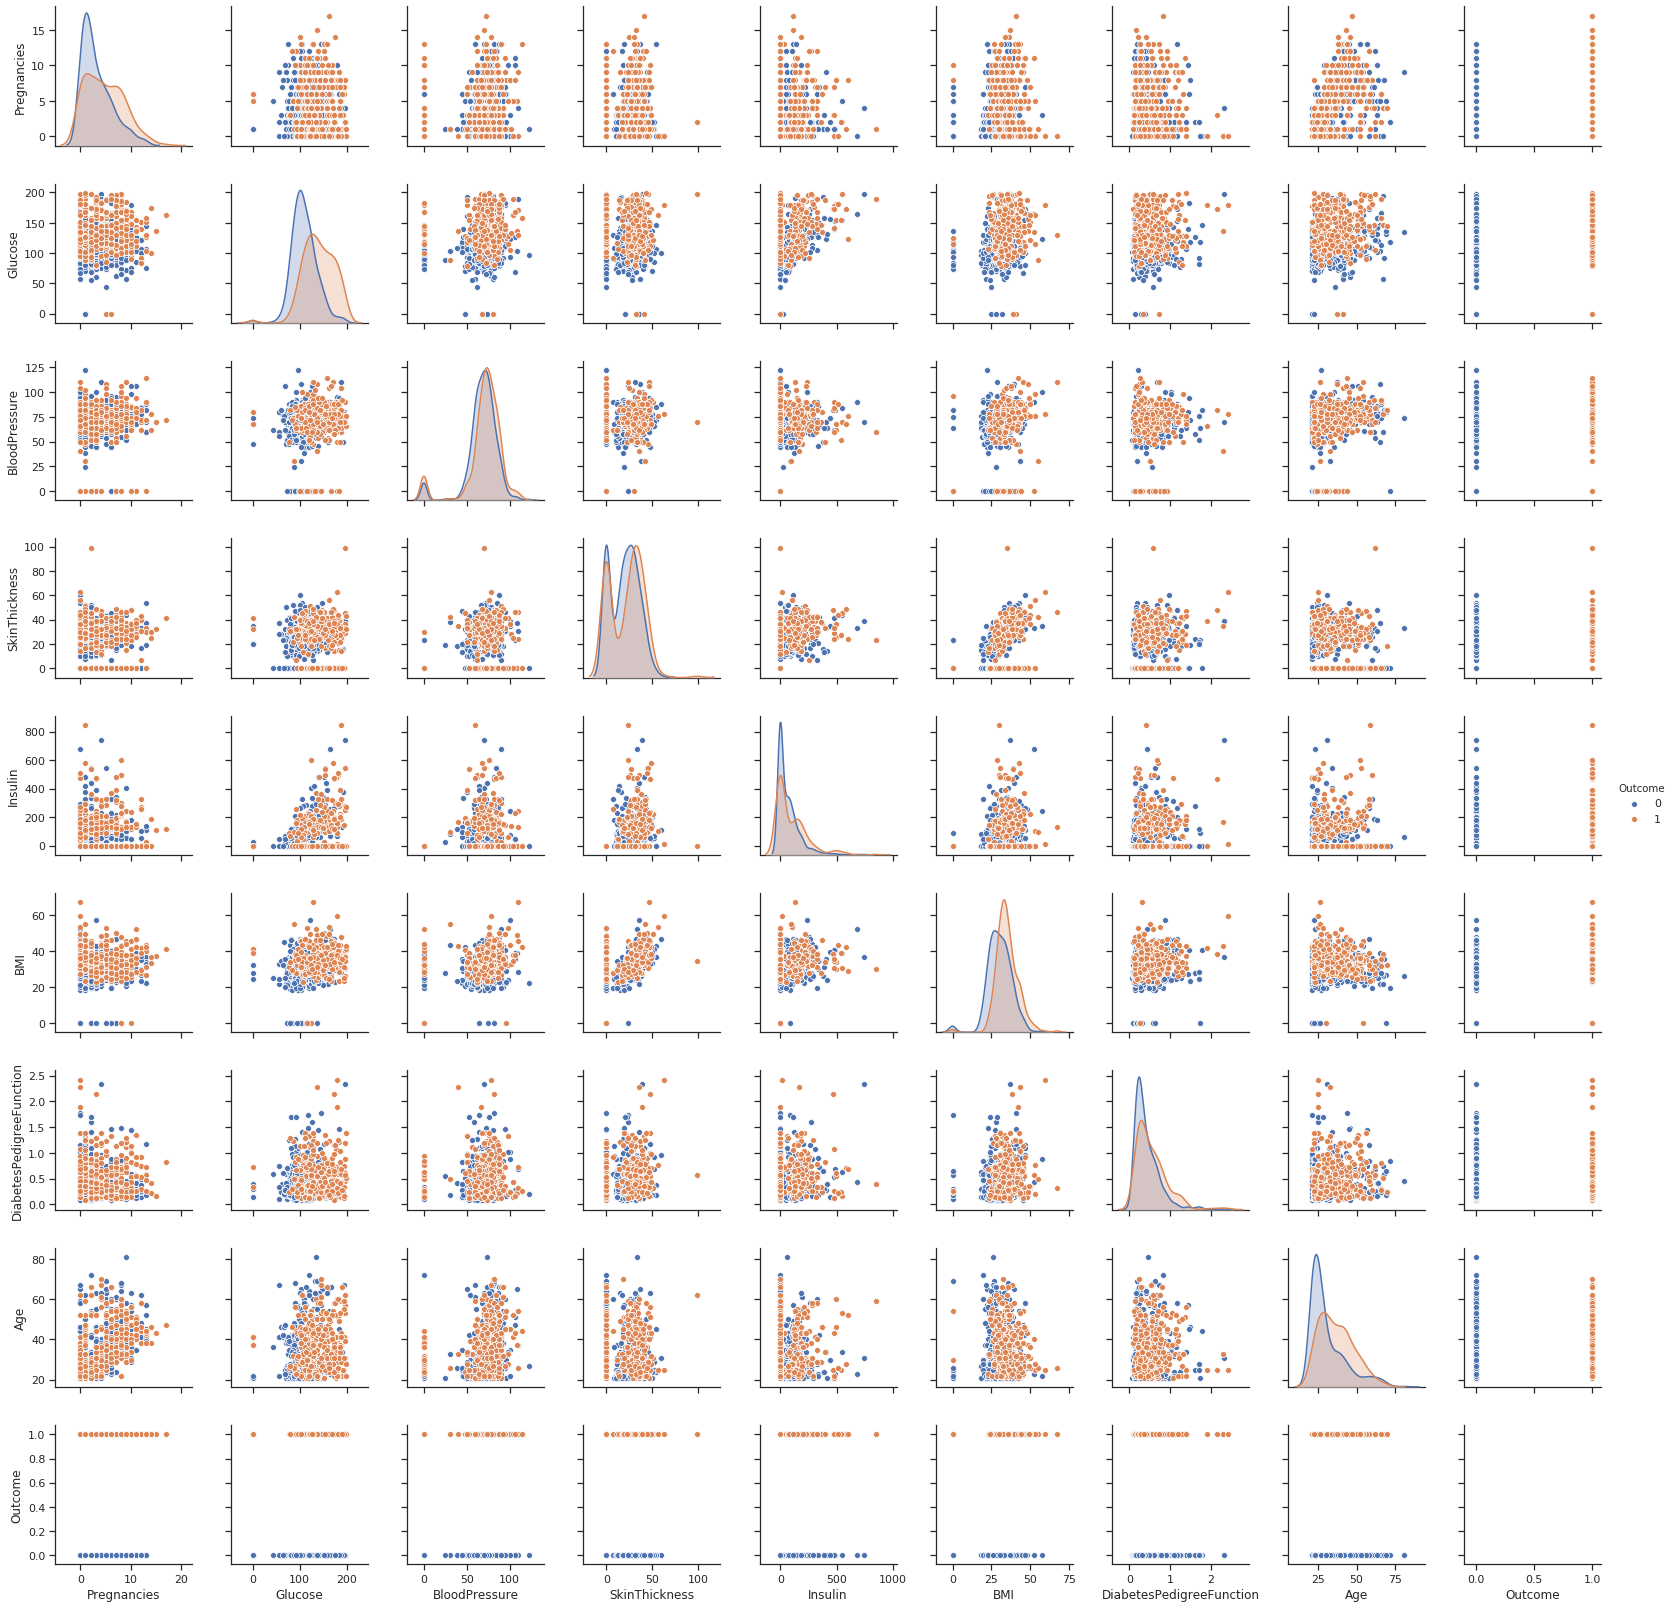

In [24]:
'''
hue ：针对某一字段进行分类
sns.pairplot(diabetes, hue="Outcome");

kind：用于控制非对角线上的图的类型，可选"scatter"与"reg"
diag_kind：控制对角线上的图的类型，可选"hist"与"kde"
sns.pairplot(diabetes,kind="reg",diag_kind="kde")

palette：控制色调
sns.pairplot(data,hue="种类",palette="husl")

#markers：控制散点的样式 
sns.pairplot(data,hue="Outcome",markers=["+", "s", "D"])


#单独用vars参数选择"萼片长 "和"花瓣长"两种属性
sns.pairplot(data,vars=["Pregnancies","Glucose"])

# 用x_vars和 y_vars参数指定
# 需要注意的是，x_vars和y_vars要同时指定
sns.pairplot(data,x_vars=["Pregnancies","Glucose"],
             y_vars=["BloodPressure","SkinThickness"]) 

'''

sns.pairplot(diabetes, hue="Outcome");

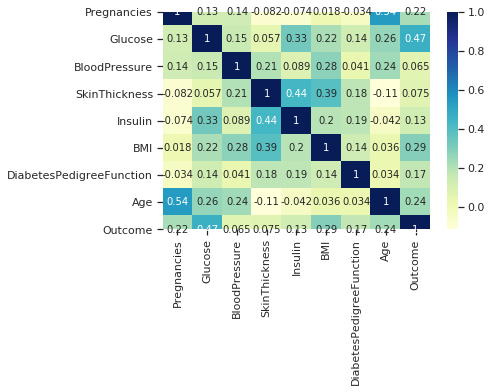

In [25]:
'''
#heatmap热度图，seaborn中常用的图

#重要点思维：拿到一批数据一般会求特征之间的相关系数，可以用pands直接求出来相关系数，放到heatmap，

可以很清楚的看到两个特征的相关程度，这是一个固定的数据思维
'''
sns.heatmap(diabetes.corr(), annot=True, cmap="YlGnBu");

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba6dff6fd0>,
      dtype=object)

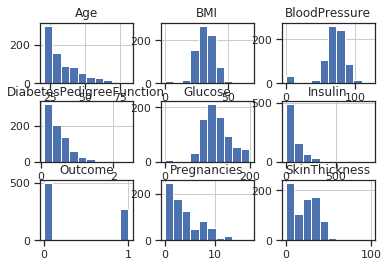

In [26]:
diabetes.hist()

In [6]:
# Possible keys for the dictionary
a = '0.65'
b = '0'
c = 'Age'
d = '0.35'
e = 'Glucose'
f = '0.5'
g = "More than zero"

# Fill in the dictionary with the correct values here
answers_one = {
    'The proportion of diabetes outcomes in the dataset':d,
    'The number of missing data points in the dataset': b,
    'A dataset with a symmetric distribution': e,
    'A dataset with a right-skewed distribution': c, 
    'This variable has the strongest correlation with the outcome': e
}

# Just to check your answer, don't change this
ch.check_one(answers_one)

Awesome! These all look great!


> **步骤 2**：因为我们的数据集非常干净，我们将直接开始机器学习步骤。我们的目标是能够预测糖尿病病例。首先，需要确定y向量和X矩阵。然后，用下面的代码将数据集划分为训练数据和测试数据。

In [27]:
y = diabetes['Outcome']
X = diabetes[['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

现在你已经有一个训练集和一个测试集，我们需要创建一些模型，并最终从中选择一个最好的模型。然而，与前面的课程中使用默认值不同，现在我们要对这些模型进行调优。

通过测试所有可能的超参数组合来找到最佳模型通常很困难（而且非常耗时）。因此，通常我们使用随机搜索。

在实践中，虽然优化的很好，但使用随机搜索来查找超参数会更耗时。这是与此主题相关的一篇[文章](https://blog.h2o.ai/2016/06/hyperparameter-optimization-in-h2o-grid-search-random-search-and-the-future/)。这是两篇介绍如何在sklearn中使用随机搜索的文档 [1](http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) 和 [2](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)。


为了有效地使用随机化搜索，你最好对超参数的常用分布有很好的理解。了解你的超参数有哪些可能值将使你能编写一个好的网格搜素算法（不中断的那种）。

> **步骤 3**：在这一步中，我将向你展示如何使用随机搜索，然后你可以在步骤4中为其他模型设置网格搜索。但是因为我不记得 SVMs 的每一个超参数具体做什么，请你帮我将每个超参数与其相应的调优函数进行匹配。

In [28]:
# build a classifier
clf_rf = RandomForestClassifier()

# Set up the hyperparameter search
param_dist = {"max_depth": [3, None],
              "n_estimators": list(range(10, 200)),
              "max_features": list(range(1, X_test.shape[1]+1)),
              "min_samples_split": list(range(2, 11)),
              "min_samples_leaf": list(range(1, 11)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


# Run a randomized search over the hyperparameters
random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Make predictions on the test data
rf_preds = random_search.best_estimator_.predict(X_test)

ch.print_metrics(y_test, rf_preds, 'random forest')

Accuracy score for random forest : 0.7597402597402597
Precision score random forest : 0.6730769230769231
Recall score random forest : 0.6363636363636364
F1 score random forest : 0.6542056074766355





> **步骤4**：现在你已经了解了如何使用随机森林模型来运行随机网格搜索，请尝试使用 AdaBoost 和 SVC 分类器执行此操作。你也可以尝试使用在本课程前面见过的其他分类器， 看看哪些分类器最有效。

In [29]:
# build a classifier for ada boost
clf_ada = AdaBoostClassifier()

# Set up the hyperparameter search
# look at  setting up your search for n_estimators, learning_rate
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
param_dist = {"n_estimators": [10, 100, 200, 400],
              "learning_rate": [0.001, 0.005, .01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 10, 20]}

# Run a randomized search over the hyperparameters
ada_search = RandomizedSearchCV(clf_ada, param_distributions=param_dist)

# Fit the model on the training data
ada_search.fit(X_train, y_train)

# Make predictions on the test data
ada_preds = ada_search.best_estimator_.predict(X_test)

# Return your metrics on test data
ch.print_metrics(y_test, ada_preds, 'adaboost')

Accuracy score for adaboost : 0.7662337662337663
Precision score adaboost : 0.6862745098039216
Recall score adaboost : 0.6363636363636364
F1 score adaboost : 0.660377358490566





In [30]:
# build a classifier for support vector machines
clf_svc = SVC()

# Set up the hyperparameter search
# look at setting up your search for C (recommend 0-10 range), 
# kernel, and degree
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
param_dist = {"C": [0.1, 0.5, 1, 3, 5],
              "kernel": ['linear','rbf']
             }


# Run a randomized search over the hyperparameters
svc_search = RandomizedSearchCV(clf_svc, param_distributions=param_dist)

# Fit the model on the training data
svc_search.fit(X_train, y_train)

# Make predictions on the test data
svc_preds = svc_search.best_estimator_.predict(X_test)


# Return your metrics on test data
ch.print_metrics(y_test, svc_preds, 'svc')

Accuracy score for svc : 0.7532467532467533
Precision score svc : 0.6545454545454545
Recall score svc : 0.6545454545454545
F1 score svc : 0.6545454545454545





> **步骤5**：使用下面的测试查看一下，你选择的最佳模型是否和我们通过网格搜索找到的一样。  

In [31]:
a = 'randomforest'
b = 'adaboost'
c = 'supportvector'

best_model =  b# put your best model here as a string or variable

# See if your best model was also mine.  
# Notice these might not match depending your search!
ch.check_best(best_model)

Nice!  It looks like your best model matches the best model I found as well!  It makes sense to use f1 score to determine best in this case given the imbalance of classes.  There might be justification for precision or recall being the best metric to use as well - precision showed to be best with adaboost again.  With recall, SVMs proved to be the best for our models.


一旦你找到了最佳模型，了解它为什么运行良好也很重要。在可以看到权重的回归模型中，可以更容易地解释结果。

> **步骤6**：尽管你的模型很难解释，但是有一些方法可以让我们知道哪些特征是重要的。使用前一个问题中选择的“最佳模型”，来查找帮助判断个体是否患有糖尿病的最重要的特征。你的结论是否与你在本notebook的数据探索阶段的预期相匹配？

In [36]:
print(diabetes.shape)

(768, 9)


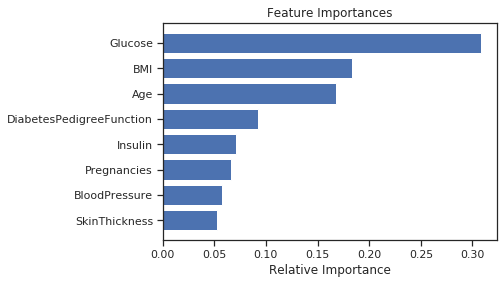

In [37]:
# Show your work here - the plot below was helpful for me
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
features = diabetes.columns[:diabetes.shape[1]]
importances = random_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

For the most part these match what I would expect based on the correlations we saw earlier between each variable and Outcome. However, one interesting finding is that pregnancy looked to be correlated with the Outcome in the exploratory findings. Though, that is likely only because pregnancy is correlated with age, and age is truly the variable that is a better indicator of diabetes.

> **步骤 7**：使用上面的结果来完成下面的字典。

In [38]:
# Check your solution by matching the correct values in the dictionary
# and running this cell
a = 'Age'
b = 'BloodPressure'
c = 'BMI'
d = 'DiabetesPedigreeFunction'
e = 'Insulin'
f = 'Glucose'
g = 'Pregnancy'
h = 'SkinThickness'



sol_seven = {
    'The variable that is most related to the outcome of diabetes' : f,
    'The second most related variable to the outcome of diabetes' : c,
    'The third most related variable to the outcome of diabetes' : a,
    'The fourth most related variable to the outcome of diabetes' : d
}

ch.check_q_seven(sol_seven)

That's right!  Some of these were expected, but some were a bit unexpected too!


> **步骤 8**:  现在总结一下，在这个notebook中你做过什么，并且你怎样把这个结果向一个非技术背景的人解释。完成后，单击左上角的橙色图标可以查看解决方案的notebook。

**In this case study, we looked at predicting diabetes for 768 patients.  There was a reasonable amount of class imbalance with just under 35% of patients having diabetes.  There were no missing data, and initial looks at the data showed it would be difficult to separate patients with diabetes from those that did not have diabetes.**

**Three advanced modeling techniques were used to predict whether or not a patient has diabetes.  The most successful of these techniques proved to be an AdaBoost Classification technique, which had the following metrics:**

Accuracy score for adaboost : 0.7792207792207793

Precision score adaboost : 0.7560975609756098

Recall score adaboost : 0.5636363636363636

F1 score adaboost : 0.6458333333333333


**Based on the initial look at the data, it is unsurprising that `Glucose`, `BMI`, and `Age` were important in understanding if a patient has diabetes.  These were consistent with more sophisticated approaches.  Interesting findings were that pregnancy looked to be correlated when initially looking at the data.  However, this was likely due to its large correlation with age.**